In [48]:
%reload_ext autoreload
%autoreload 2
    
from tqdm import tqdm

from pathlib import Path
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

import tasks
import models

from sklearn.decomposition import PCA
from rastermap import Rastermap

device = "cuda" if torch.cuda.is_available() else "cpu"

filepath = Path("~/Documents/Kempner/MCN2024/jobs/")
filepath = filepath.expanduser()

from analysis import load_job, load_results, load_weight_changes, equal_axes

In [68]:
jobid = 47
init_prms, final_prms = load_weight_changes(jobid)

jobids = [43, 44, 45, 46, 47]
cols = 'krbgm'
color = cols[jobids.index(jobid)]

In [70]:
final_prms["hidden_tau"]

tensor([[0.1695, 4.8111, 0.0549,  ..., 0.5828, 4.5539, 7.8718],
        [0.3748, 0.0887, 1.2121,  ..., 0.3109, 1.0953, 1.3957],
        [6.7929, 0.3281, 0.3399,  ..., 0.5508, 0.0794, 2.6294],
        ...,
        [1.0899, 3.5813, 5.3005,  ..., 0.9171, 0.1169, 0.2092],
        [0.4981, 0.4345, 1.4579,  ..., 9.7536, 0.1819, 0.4352],
        [0.3953, 0.0788, 9.7018,  ..., 0.3441, 1.0204, 1.1249]])

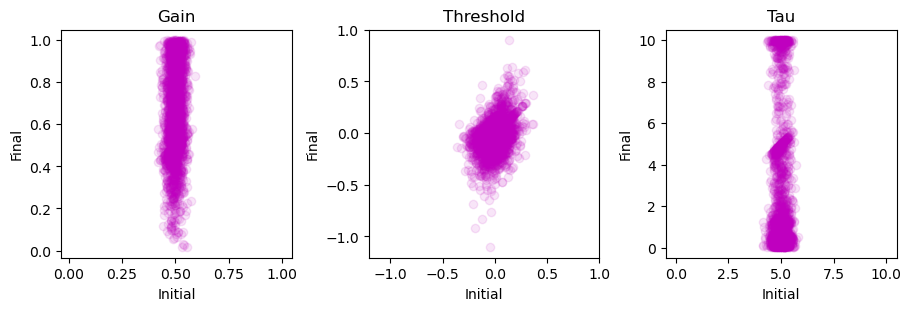

In [67]:

fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
ax[0].scatter(init_prms["hidden_gain"], final_prms["hidden_gain"], c=color, alpha=0.1)
ax[0].set_xlabel("Initial")
ax[0].set_ylabel("Final")
ax[0].set_title("Gain")
equal_axes(ax[0])

ax[1].scatter(init_prms["hidden_threshold"], final_prms["hidden_threshold"], c=color, alpha=0.1)
ax[1].set_xlabel("Initial")
ax[1].set_ylabel("Final")
ax[1].set_title("Threshold")
equal_axes(ax[1])

ax[2].scatter(init_prms["hidden_tau"], final_prms["hidden_tau"], c=color, alpha=0.1)
ax[2].set_xlabel("Initial")
ax[2].set_ylabel("Final")
ax[2].set_title("Tau")
equal_axes(ax[2])

figure_name = "weight_changes"
plt.savefig(f"../project/{figure_name}_{jobid}")
plt.show()

In [71]:
# Load trained model and results

jobid = 43
model_index = 11
model, results, init_model = load_job(jobid, model_index=model_index, init=True)

args = results["args"]
task_params = results["task"]
train_loss = results["train_loss"]
train_accuracy = results["train_accuracy"]
train_evidence = results["train_evidence"]
train_fixation = results["train_fixation"]

task = tasks.ContextualGoNogo(
    args["input_dimensions"],
    args["end_sigma"],
    num_contexts=task_params["num_contexts"],
    stim_time=task_params["stim_time"],
    delay_time=args["end_delay"],
    decision_time=task_params["decision_time"],
    task_type=args["task_type"] if "task_type" in args else "embedded",
)
task.cursors = task_params["cursors"]

if args["network_type"] == "Gain":
    model_constructor = models.GainRNN
elif args["network_type"] == "Tau":
    model_constructor = models.TauRNN
elif args["network_type"] == "Full":
    model_constructor = models.FullRNN
elif args["network_type"] == "Intrinsic":
    model_constructor = models.IntrinsicRNN
else:
    raise ValueError("Unknown network type")


kwargs = dict(
    gainfun=args["gainfun"],
    taufun=args["taufun"],
    tauscale=args["tauscale"],
)
if args["network_type"] != "Full":
    kwargs["input_rank"] = args["input_rank"]
    kwargs["recurrent_rank"] = args["recurrent_rank"]

net = model_constructor(
    task.input_dimensionality(),
    args["num_neurons"],
    task.output_dimensionality(),
    **kwargs,
)

net.load_state_dict(model)

<All keys matched successfully>

tensor([1.3091, 0.3171, 1.3175, 0.1174, 0.3924, 0.6770, 1.1135, 1.7846, 0.0694,
        0.4153, 0.5083, 1.0804, 0.7755, 0.6159, 0.1026, 1.3084, 0.5558, 0.3683,
        0.9887, 0.1868, 0.2765, 1.6660, 0.3699, 0.8225, 0.3341, 0.9045, 1.1994,
        0.1999, 0.3100, 0.6965, 0.2681, 1.2669, 0.0478, 0.2916, 0.1085, 0.0776,
        0.2470, 0.3405, 0.4759, 1.3493, 0.7641, 0.7435, 0.7532, 0.0276, 1.0416,
        0.7983, 1.1244, 0.5528, 1.4984, 0.7022, 0.5874, 0.4895, 0.6856, 0.9172,
        0.1636, 0.9970, 0.1080, 1.0797, 0.8856, 0.0396, 0.1415, 0.5040, 0.4958,
        0.6705])


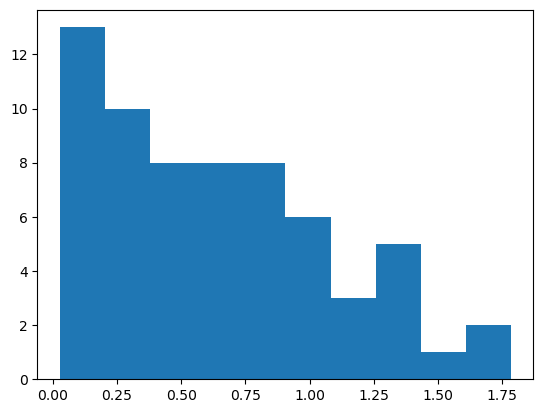

In [81]:
xx = torch.sigmoid(net.hidden_tau.detach().clone())
yy = xx + 0.5 * torch.randn_like(xx) * xx

# inverse sigmoid
# zz = torch.log(yy / (1 - yy))

print(yy)
plt.hist(yy)
plt.show()

In [5]:
X, target, params = task.generate_data(10000, sigma=0.1, source_floor=0.5, source_strength=1.0)
output, hidden = net(X, return_hidden=True)
output = output.detach()

all_hidden = np.array(hidden.view(-1, hidden.size(2)).detach()).T
pca = PCA(n_components=4).fit(all_hidden.T)
isort = torch.tensor(np.argsort(pca.components_[0]))

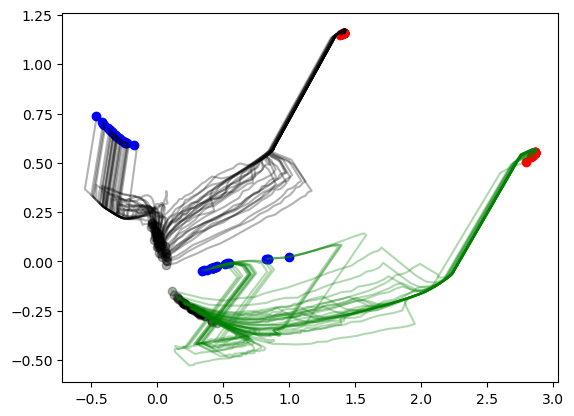

In [117]:
# task.decision_time = 
X, target, params = task.generate_data(100, source_floor=0.15, source_strength=1.5)
output, hidden = net(X, return_hidden=True)
output = output.detach()

context_idx = params["context_idx"]
labels = params["labels"]

pc_hidden = hidden.detach().numpy() @ pca.components_.T[:, [0, 1]]

fig = plt.figure()
plt.plot(pc_hidden[context_idx==0, :, 0].T, pc_hidden[context_idx==0, :, 1].T, c='k', alpha=0.3)
plt.plot(pc_hidden[context_idx==1, :, 0].T, pc_hidden[context_idx==1, :, 1].T, c='g', alpha=0.3)
plt.scatter(pc_hidden[:, 0, 0], pc_hidden[:, 0, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[labels==0, -1, 0], pc_hidden[labels==0, -1, 1], c='b')
plt.scatter(pc_hidden[labels==1, -1, 0], pc_hidden[labels==1, -1, 1], c='r')
plt.show()

fig = plt.figure()
plt.plot(pc_hidden[context_idx==0, :, 0].T, pc_hidden[context_idx==0, :, 1].T, c='k', alpha=0.3)
plt.plot(pc_hidden[context_idx==1, :, 0].T, pc_hidden[context_idx==1, :, 1].T, c='g', alpha=0.3)
plt.scatter(pc_hidden[:, 0, 0], pc_hidden[:, 0, 1], c='k', alpha=0.3)
plt.scatter(pc_hidden[labels==0, -1, 0], pc_hidden[labels==0, -1, 1], c='b')
plt.scatter(pc_hidden[labels==1, -1, 0], pc_hidden[labels==1, -1, 1], c='r')
plt.show()

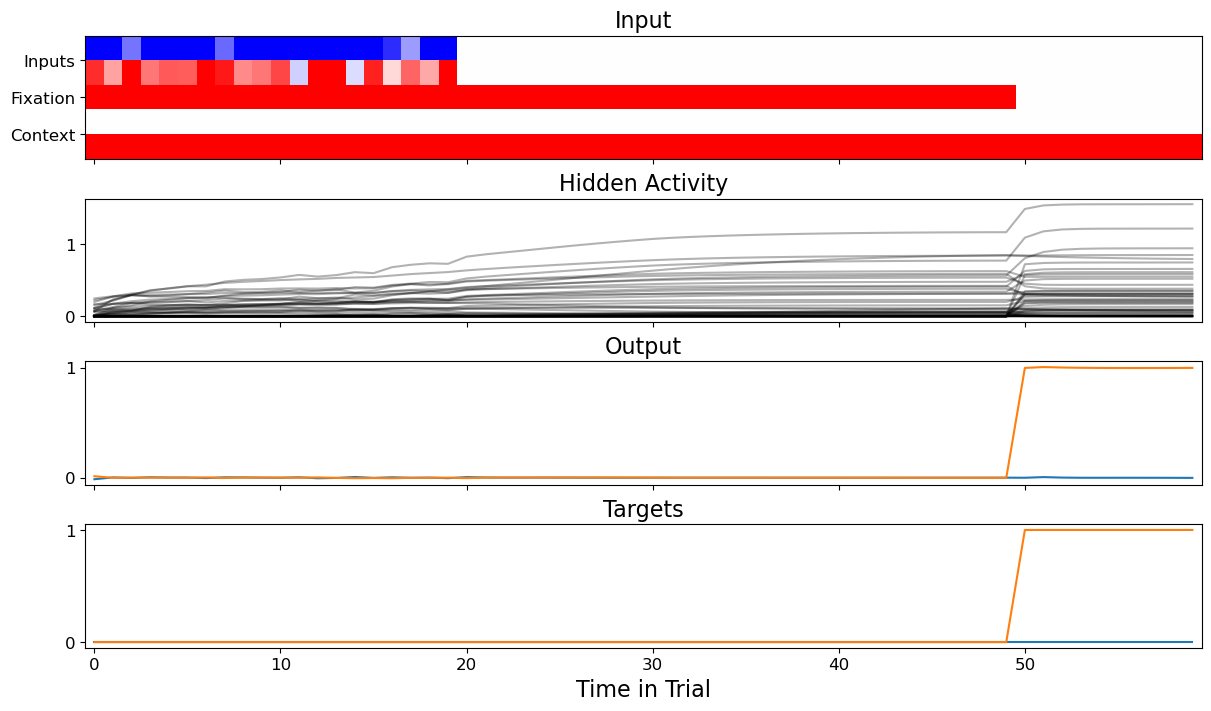

In [139]:
ibatch = 0

# task.decision_time = 
X, target, params = task.generate_data(1, source_floor=0.5, source_strength=1.0, sigma=0.5)
output, hidden = net(X, return_hidden=True)
output = output.detach()

fontsize = 16
smallfont = 12
fig, ax = plt.subplots(4, 1, figsize=(12, 7), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto", cmap="bwr", interpolation="none", vmin=-1, vmax=1)
ax[0].set_yticks([0.5, 2, 3.5], labels=["Inputs", "Fixation", "Context"], fontsize=smallfont)
ax[0].set_title("Input", fontsize=fontsize)
ax[1].plot(hidden[ibatch].detach().numpy()[:, isort], c='k', alpha=0.3)
# ax[1].imshow(hidden[ibatch].detach().numpy().T[isort], aspect="auto", interpolation="none", cmap='gray')
ax[1].tick_params(axis="y", labelsize=smallfont)
ax[1].set_title("Hidden Activity", fontsize=fontsize)
ax[2].plot(output[ibatch].detach().numpy(), label="Network Output")
ax[2].set_title("Output", fontsize=fontsize)
ax[2].set_yticks([0, 1])
ax[2].tick_params(axis="y", labelsize=smallfont)
ax[3].plot(target[ibatch].detach().numpy(), label="Target")
ax[3].set_title("Targets", fontsize=fontsize)
ax[3].set_xlabel("Time in Trial", fontsize=fontsize)
ax[3].set_yticks([0, 1])
ax[3].tick_params(axis="y", labelsize=smallfont)
ax[3].tick_params(axis='x', labelsize=smallfont)
plt.show()

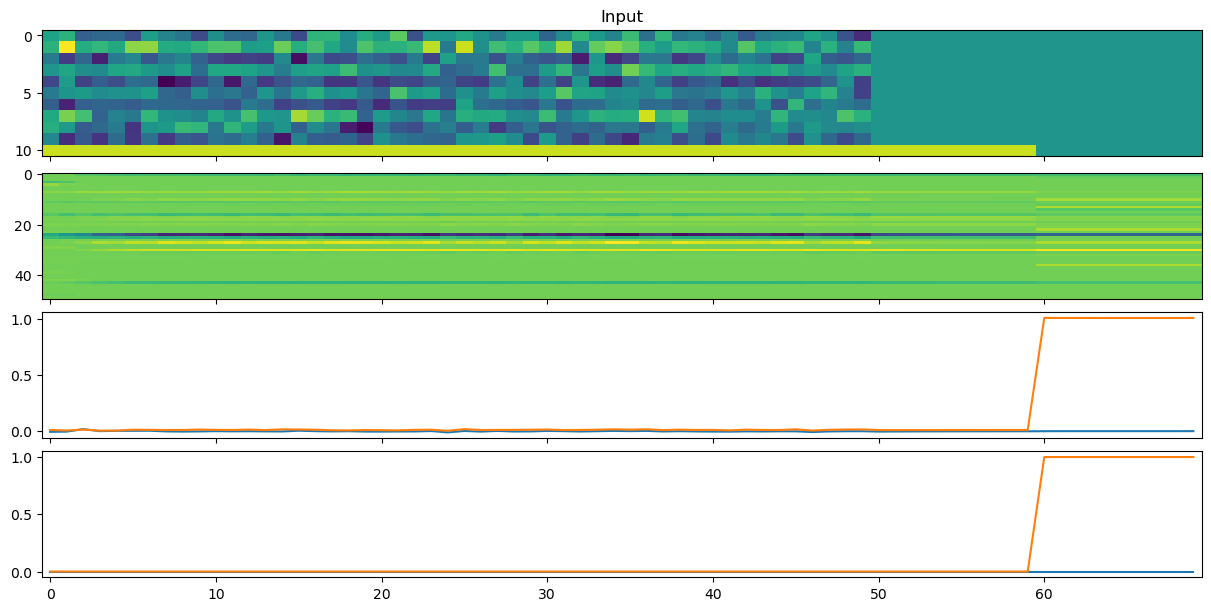

In [38]:
ibatch = 1

fig, ax = plt.subplots(4, 1, figsize=(12, 6), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[0].set_title("Input")
ax[1].imshow(hidden[ibatch].detach().numpy().T, aspect="auto", interpolation="none")
ax[2].plot(outputs[ibatch].detach().numpy(), label="Output")
ax[3].plot(target[ibatch].detach().numpy(), label="Target")
plt.show()

In [6]:
params["s_empirical"][:10]

tensor([-0.0974,  0.0866, -0.0177,  0.0962, -0.0976, -0.0620, -0.0904,  0.0902,
         0.0977, -0.0929])

Beta: Parameter containing:
tensor(0.8745, requires_grad=True) Alpha: Parameter containing:
tensor([0.6411, 0.8757], requires_grad=True)
torch.Size([11, 2]) torch.Size([2, 2])


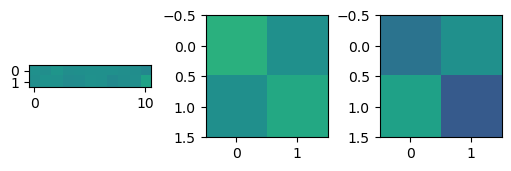

In [54]:
ipweight = net.input_weight.weight.detach().T
rcweight = net.recurrent_weight.weight.detach()
roweight = net.readout.weight.detach()
sd_score = roweight[0] - roweight[1]
isort = torch.argsort(sd_score)

print("Beta:", net.rnn.beta, "Alpha:", net.rnn.alpha)
print(ipweight.shape, rcweight.shape)

fig, ax = plt.subplots(1, 3, figsize=(5, 4), layout="constrained")
ax[0].imshow(ipweight.T[isort], vmin=-1, vmax=1)
ax[1].imshow(rcweight.T[isort][:, isort], vmin=-1, vmax=1)
ax[2].imshow(roweight.T[isort], vmin=-1, vmax=1)
plt.show()

In [44]:
ipweight.T

tensor([[-3.0019e-03,  8.0061e-03, -4.9607e-04, -7.6670e-03, -1.8169e-02,
          1.4057e-02, -5.0839e-03, -1.8974e-02,  3.1144e-03, -1.9640e-03,
          3.6878e-01],
        [ 9.8980e-04, -1.1440e-02, -8.7633e-04, -2.0143e-05, -2.5359e-03,
         -3.1783e-06, -3.8885e-02,  9.0732e-03, -1.1556e-05, -1.2034e-02,
          2.1957e-02]])

In [7]:
X, labels, params = task.generate_data(B)
outputs, spks, mems = net(X, start_integration=start_integration)
choice = torch.argmax(outputs, dim=1)

torch.cat((params["stimuli"][:10], labels[:10].unsqueeze(1), choice[:10].unsqueeze(1)), dim=1)

TypeError: ContextualGoNogo.generate_data() missing 1 required positional argument: 'T'

In [ ]:
ibatch = 8

print(X[ibatch].shape, spks[ibatch].shape, mems[ibatch].shape)

fig, ax = plt.subplots(3, 1, figsize=(9, 6), layout="constrained")
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[1].imshow(spks[ibatch][:, isort].detach().T, aspect="auto")
ax[2].imshow(mems[ibatch][:, isort].detach().T, aspect="auto")
plt.show()